In [1]:
from common import utils
import random
u=utils("PDF+SOL") # PDF+SOL / PROF / PDF / INTER

Ce cours a été régénéré le 2019-11-08 01:33:35.058244. Mode avec corrigé. Mode statique.


# Les processus

## Les types de programmes

Les instructions qui sont exécutées sur l'ordinateur sont toutes écrites dans le même langage, qui est celui qui est compris par le processeur : le langage machine. Ce langage est composé de nombres, qui sont ensuite traduits en action à faire au niveau électronique du processeur, permet de contrôler l'action du processeur sur ses composants : déplacement de valeurs entre registres, communication avec la mémoire principale, communications basiques avec le reste des périphériques (souvent en modifiant des adresses mémoires réservées), opérations arithmétiques et logiques, changement de l'adresse d'exécution (avec ou sans conditions)...

Ce langage est directement compréhensible par l'ordinateur, mais ne l'est pas par les humains (il est éventuellement déchiffrable, mais c'est pénible). Les humains, pour programmer, utilisent donc d'autres langages, plus symboliques.

### Les programmes compilés

Le premier de ces langages est le _[langage assembleur](https://fr.wikipedia.org/wiki/Assembleur)_. Au lieu de décrire par des nombres les actions sur le processeur, il le décrit par des « verbes » élémentaires, inspirés de l'anglais et des notations qui permettent de décrire comment on prépare les données. Ce langage est en traduction directe vers l'assembleur : il n'y a pas un concept disponible en _assembleur_ qui ne soit pas traduit de façon automatique par plus de 2-3 instructions en _langage machine_.

    .text
    .global _start

    _start:
    movl $4, %eax ; $4 = appel système write
    movl $1, %ebx ; $1 = descripteur de fichier 1
    movl $str, %ecx ; $str = adresse de la chaîne
    movl $8, %edx ; $8 = longueur
    int $0x80     ; appel système ($0x80)
    movl $1, %eax ; $1 = appel système exit
    movl $0, %ebx ; $0 = tout va bien
    int $0x80     ; appel système ($0x80)

    .data
    str:
     .ascii "Bonjour\n"    

La traduction en français de ce programme est : « mettre dans les registres `eax`, `ebx`, `ecx` et `edx` les valeurs 4, 1, l'adresse `str` (qui correspond au début d'une chaîne qui contient "Bonjour" avec retour à la ligne et caractère nul de terminaison) et 8. Ensuite le `int 0x80` dit de déclencher l'interruption numéro 80, qui correspond (sous Linux) au fait de faire un appel système. Le processeur exécute alors un appel système (il se trouve que pour eax=4, c'est l'appel système `write` qui va donc écrire sur le descripteur de fichier numéro 1 (parce que ebx vaut 1 — c'est donc la sortie STDOUT) une série de 8 caractères (parce que edx vaut 8) stockés à l'adresse `str` (parce que ecx vaut `str`). Les trois dernières lignes font de même, en invoquant cette fois l'appel système 1, comme on peut le lire dans [cette table](https://syscalls.kernelgrok.com/), qui est l'appel `exit` (dont l'effet est exactement ce qu'on suppose : quitter le programme).

Comme on peut le constater, cette syntaxe est plus facile à comprendre que sa traduction numérique, mais encore ardue. Un spécialiste peut le faire, mais pas le développeur qui a d'autres préoccupations.


In [2]:
u.activite("Compilation d'un programme en assembleur (très facultatif)")
u.mark(r'''
Tapez dans un terminal le programme suivant :

    echo '
    .text
    .global _start

    _start:
    movl $4, %eax ; $4 = appel système write
    movl $1, %ebx ; $1 = descripteur de fichier 1
    movl $str, %ecx ; $str = adresse de la chaîne
    movl $8, %edx ; $8 = longueur
    int $0x80     ; appel système ($0x80)
    movl $1, %eax ; $1 = appel système exit
    movl $0, %ebx ; $0 = tout va bien
    int $0x80     ; appel système ($0x80)

    .data
    str:
     .ascii "Bonjour\n"    

    '| sed -e 's/;.*$//g' > /tmp/monasm.s

    as -o /tmp/monasm.o /tmp/monasm.s
    ld /tmp/monasm.o -o /tmp/monasm 
    # gcc --verbose -nostdlib -m32 -o /tmp/monasm /tmp/monasm.s
    /tmp/monasm
''')

#### Activité : Compilation d'un programme en assembleur (très facultatif)


Tapez dans un terminal le programme suivant :

    echo '
    .text
    .global _start

    _start:
    movl $4, %eax ; $4 = appel système write
    movl $1, %ebx ; $1 = descripteur de fichier 1
    movl $str, %ecx ; $str = adresse de la chaîne
    movl $8, %edx ; $8 = longueur
    int $0x80     ; appel système ($0x80)
    movl $1, %eax ; $1 = appel système exit
    movl $0, %ebx ; $0 = tout va bien
    int $0x80     ; appel système ($0x80)

    .data
    str:
     .ascii "Bonjour\n"    

    '| sed -e 's/;.*$//g' > /tmp/monasm.s

    as -o /tmp/monasm.o /tmp/monasm.s
    ld /tmp/monasm.o -o /tmp/monasm 
    # gcc --verbose -nostdlib -m32 -o /tmp/monasm /tmp/monasm.s
    /tmp/monasm



On utilise donc pour la plupart des développements non pas l'assembleur, mais un langage de haut niveau qui permet de faire la même chose de façon plus lisible.

    #include <unistd.h>
    
    char *str="Bonjour\n";
    
    int main() {
        write(1,str,8);
        return(0);
    }

Ce programme est rédigé en **langage C** et comprend des aspects plus familiers : on peut utiliser des noms de variable, des types de données, des fonctions, la possibilité d'avoir des bibliothèques de fonctions pré-programmées... La fonction `main` a un rôle particulier d'être la fonction appellée au démarrage du programme et la valeur qu'elle retourne est renvoyée par l'appel système `exit` à la fin. Ce programme est la traduction du programme en assembleur présenté plus haut. Ou plus précisément, le programme va lui être traduit en assembleur (qui sera ensuite traduit lui-même en langage machine) avant d'être exécuté.

La possibilité d'avoir des *bibliothèques* de fonctions pré-programmées permet d'enrichir énormément un langage : par exemple, un programmeur C normal utiliserait plutôt le code suivant :


    #include <stdio.h>
    
    char *str="Bonjour\n";
    
    int main() {
        printf(str);
        return(0);
    }

Mais l'utilisation de bibliothèques de fonctions complique souvent la chaîne de fabrication d'un programme. En particulier, les fonctions pré-programmées, il faut les ajouter. Et il est possible de les ajouter directement, ou d'attendre le moment de l'exécution pour les ajouter, ce qui amène à un schéma plus complexe. L'ajout de bibliothèques de fonctions (le programme n'étant lui-même qu'une bibliothèque de fonction qui comprend la fonction `main`) suit donc le schéma ci-dessous.

Figure `compilation1*`.

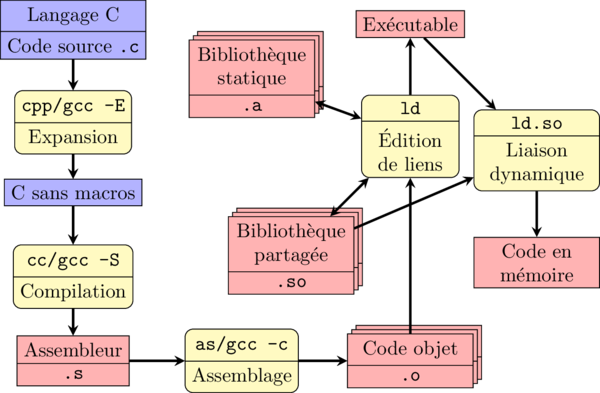

In [3]:
u.tikz("compilation1","-l shapes.multipart,shadows -s 600,400",r'''
      \tikzstyle{double}=[rectangle split,rectangle split parts=2,draw=black,fill=red!30]
      \tikzstyle{single}=[shape=rectangle,draw=black,fill=red!30]
      \tikzstyle{trans}=[shape=rectangle split,rectangle split parts=2,draw=black,fill=yellow!30,text centered,rounded corners]
      \tikzstyle{multi}=[double copy shadow,sized]
      \tikzstyle{sized}=[text width=2cm,text centered]
      \tikzstyle{indep}=[fill=blue!30]
      \node[double,indep] (C) at (0,5.9) {%
        Langage C 
        \nodepart{second} Code source \texttt{.c}
      };
      \node[trans] (cpp) at (0,4.25) {
        \texttt{cpp/gcc -E} \nodepart{second} Expansion
      };
      \node[single,indep] (Cex) at (0,3) {%
        C sans macros
      };
      \node[trans] (cc) at (0,1.5) {
        \texttt{cc/gcc -S} \nodepart{second} Compilation
      };
      \node[double] (ASM) at (0,0) {%
        Assembleur 
        \nodepart{second} \texttt{.s}
      };
      \node[trans] (as) at (3,0) {
        \texttt{as/gcc -c} \nodepart{second} Assemblage
      };
      \draw node[double,sized] (OBJ) at (6,0) {%
        Code objet 
        \nodepart{second} \texttt{.o}
      };
      \foreach \x/\y in {C/cpp,cpp/Cex,Cex/cc,cc/ASM,ASM/as,as/OBJ} {
        \draw[very thick,-stealth] (\x)--(\y);
      }
        \draw node[double,multi] (OBJ) at (6,0) {%
          Code objet 
          \nodepart{second} \texttt{.o}
        };
        \node[trans,sized,text width=15mm] (ld) at (6,4) {%
          \texttt{ld} \nodepart{second} Édition de liens
        };
        \draw (ld) +(225:3) node[double,multi] (SO) {%
          Bibliothèque partagée 
          \nodepart{second} \texttt{.so}
        };
        \draw (ld) +(160:3) node[double,multi] (SL) {%
          Bibliothèque statique 
          \nodepart{second} \texttt{.a}
        };
        \draw (ld) +(90:2) node[single] (EXE) {%
          Exécutable
        };
        \draw (EXE) +(2.25,-2.25) node[trans,sized] (ldso) {%
          \texttt{ld.so} \nodepart{second} Liaison dynamique
        };
        \draw (ldso) +(0,-2) node[single,sized] (machine) {%
          Code en mémoire
        };
        \foreach \x/\y in {C/cpp,cpp/Cex,Cex/cc,cc/ASM,ASM/as,as/OBJ,OBJ/ld,ld/EXE,EXE/ldso,ldso/machine,SO/ldso} {
          \draw[very thick,-stealth] (\x)--(\y);
        }
        \foreach \x/\y in {ld/SL,ld/SO} {
          \draw[very thick,stealth-stealth] (\x)--(\y);
        }

''')

In [4]:
u.activite("La compilation")
# Questions :
u.mark("Y a-t-il des avantages à programmer directement en langage machine ? Lesquels ?")
u.solution("Aucun, la phase d'assemblage est très simple pour un ordinateur, elle est très très peu susceptible d'introduire des bugs. La traduction inverse (désassemblage) est même possible.")
u.mark("Y a-t-il des avantages à programmer directement en assembleur ? Lesquels ?")
u.solution("parfois, les compilateurs peuvent ne pas voir certaines optimisations possibles, ou rajouter du code que le programmeur peut savoir inutile pour respecter des protocoles ou des conventions d'écriture. Toutefois, ces cas sont très rares. Le code obtenu à la main peut aussi être plus petit ce qui peut avoir de l'importance dans le cas de programmation sur des appareils à faible mémoire.")
u.mark("Y a-t-il des avantages à programmer sans macros ? Lesquels ?")
u.solution("non, pas vraiment. Lorsqu'elles ne sont pas nécessaires il suffit de ne pas les utiliser, c'est le même langage avant et après interprétation des macros.")
u.mark("Y a-t-il des avantages à faire l'édition de liens au moment de l'exécution ? Lesquels ?")
u.solution("Réponse : une fois l'exécutable fabriqué, il est figé. S'il y a un bug dans une des fonctions de bibliothèques partagées, le bug peut être corrigé dans la bibliothèque, mais si elle a déjà été adjointe au programme, c'est trop tard — le bug est encore présent (on peut remplacer bug par « nouvelle version avec un fonctionnement meilleur »). Un inconvénient en revanche, c'est que le système doit avoir accès à la bibliothèque partagée au moment de l'exécution, l'exécutable n'est pas « autonome ».")
u.mark("Dans un terminal, regarder le résultat de ldd /bin/ls et objdump -d /bin/ls | less (rapidement pour objdump")

#### Activité : La compilation

Y a-t-il des avantages à programmer directement en langage machine ? Lesquels ?

Votre proposition > `_____________________________________________________`

**Solution:** Aucun, la phase d'assemblage est très simple pour un ordinateur, elle est très très peu susceptible d'introduire des bugs. La traduction inverse (désassemblage) est même possible.

Y a-t-il des avantages à programmer directement en assembleur ? Lesquels ?

Votre proposition > `_____________________________________________________`

**Solution:** parfois, les compilateurs peuvent ne pas voir certaines optimisations possibles, ou rajouter du code que le programmeur peut savoir inutile pour respecter des protocoles ou des conventions d'écriture. Toutefois, ces cas sont très rares. Le code obtenu à la main peut aussi être plus petit ce qui peut avoir de l'importance dans le cas de programmation sur des appareils à faible mémoire.

Y a-t-il des avantages à programmer sans macros ? Lesquels ?

Votre proposition > `_____________________________________________________`

**Solution:** non, pas vraiment. Lorsqu'elles ne sont pas nécessaires il suffit de ne pas les utiliser, c'est le même langage avant et après interprétation des macros.

Y a-t-il des avantages à faire l'édition de liens au moment de l'exécution ? Lesquels ?

Votre proposition > `_____________________________________________________`

**Solution:** Réponse : une fois l'exécutable fabriqué, il est figé. S'il y a un bug dans une des fonctions de bibliothèques partagées, le bug peut être corrigé dans la bibliothèque, mais si elle a déjà été adjointe au programme, c'est trop tard — le bug est encore présent (on peut remplacer bug par « nouvelle version avec un fonctionnement meilleur »). Un inconvénient en revanche, c'est que le système doit avoir accès à la bibliothèque partagée au moment de l'exécution, l'exécutable n'est pas « autonome ».

Dans un terminal, regarder le résultat de ldd /bin/ls et objdump -d /bin/ls | less (rapidement pour objdump

In [5]:
u.activite("Compilation d'un programme élémentaire")
# Taper le programme suivant
u.mark(r'''Soit le programme suivant
    #include <unistd.h>
    
    char *str="Bonjour\n";
    
    int main() {
        write(1,str,8);
        return(0);
    }
Sauvez-le dans un fichier hello.c puis faites successivement:

    cpp hello.c -o hello_sans_macros.c
    cc -o hello.s -S hello_sans_macros.c
    as -o hello.o hello.s
    gcc -o hello hello.o # on pourrait utiliser ld directement mais la ligne à taper fait plus de 1000 caractères

Comparez ensuite `hello.c` et `hello_sans_macros.c`.
Comparez ensuite `hello.s` et le résultat de `objdump -d hello.o`.
Trouvez s'il reste des bibliothèques dynamiques à lier au moment de l'exécution avec `ldd ./hello` (3 normalement).
Enfin, testez que le programme fonctionne en lançant `./hello`.
''')

#### Activité : Compilation d'un programme élémentaire

Soit le programme suivant
    #include <unistd.h>
    
    char *str="Bonjour\n";
    
    int main() {
        write(1,str,8);
        return(0);
    }
Sauvez-le dans un fichier hello.c puis faites successivement:

    cpp hello.c -o hello_sans_macros.c
    cc -o hello.s -S hello_sans_macros.c
    as -o hello.o hello.s
    gcc -o hello hello.o # on pourrait utiliser ld directement mais la ligne à taper fait plus de 1000 caractères

Comparez ensuite `hello.c` et `hello_sans_macros.c`.
Comparez ensuite `hello.s` et le résultat de `objdump -d hello.o`.
Trouvez s'il reste des bibliothèques dynamiques à lier au moment de l'exécution avec `ldd ./hello` (3 normalement).
Enfin, testez que le programme fonctionne en lançant `./hello`.


Outre la possibilité de faire faire un travail important d'optimisation (et de performance) par l'ordinateur à la compilation, un autre intérêt de la compilation est aussi de pouvoir faire des vérifications statiques sur le programme, avant même de l'exécuter. Par exemple, il est possible de détecter dans certains cas si un morceau de code ne va jamais être exécuté (ce qui est une erreur, dans la plupart des cas). Ce travail d'inspection prend trop de temps pour être fait au lancement du programme (exécution), mais peut très bien s'insérer dans la chaîne de production du logiciel.


Quelques autres langages compilés :

  * Le C et beaucoup de ses variantes : C++, C#, Smalltalk
  * COBOL
  * Fortran
  * Parmi des additions plus récentes, on peut au moins compter Go et Rust


### Les programmes interprétés

La compilation a des avantages, mais aussi des inconvénients. L'inconvénient le plus flagrant est la *portabilité*, c'est-à-dire la possibilité de faire un programme exécutable sur plusieurs plateformes. Comme le langage machine est spécifique à une famille de processeurs, que les bibliothèques de fonctions pré-programmées le sont aussi... un programme copié sur un système différent ne fonctionnera pas forcément, même si le système d'exploitation reste le même.

Il est possible de trouver la portabilité au niveau source (une recompilation permet d'obtenir un programme fonctionnel sur la nouvelle plateforme), mais plus le nombre de plateformes cibles est grand, plus c'est difficile. Et le travail est à faire sur chaque programme !

Il existe une autre façon de faire un programme portable. Si on fabrique un programme paramétrable, qui lit des instructions dans une sorte de langage universel, et qui agit sur ses zones de mémoire pour simuler des variables, des opérations, etc. en fonction de ce langage universel, il suffit de porter pour une nouvelle plateforme uniquement l'interpréteur de ce langage universel, et tous les programmes fonctionneront. C'est ce qu'on appelle des *interpréteurs*, qui servent ensuite à exécuter des programmes dans des langages *interprétés*. Les fichiers d'instruction dans le langage interprété sont souvent appelés des scripts.

Quelques exemples de tels langages de programmation :

  * Le shell (bash par exemple, il en existe d'autres : ksh, zsh, MS-DOS...)
  * Python
  * Perl, Ruby, PHP, ASP (des langages assez différents, utilisés surtout dans le domaine du web)
  * Plusieurs langages de calcul scientifiques : R, Matlab, octave, gnuplot
  * Makefile
  * SQL dans le domaine des bases de données
  * Postscript, pour décrire les instructions graphiques qui pilotent la plupart des imprimantes
  * Scheme (une variante de son ancêtre Lisp) dans la catégorie des langages fonctionnels (un type de programmation)
  
Les programmes interprétés (scripts) sont donc en fait « lus » par l'interpréteur, qui le déchiffre pas à pas et « simule » les effets du programme (mais les effets de la « simulation » sont, eux, biens réels). À aucun moment, c'est le script lui-même qui est lu comme du code ; c'est l'interpréteur qui est exécuté (et son exécution « déroule » le script).

Figure `compilation2*`.

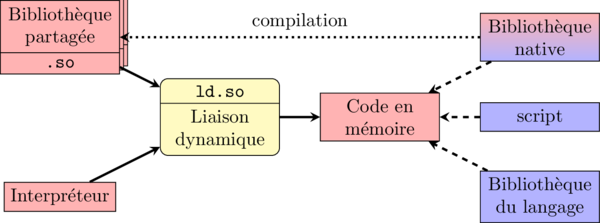

In [6]:
u.tikz("compilation2","-l shapes.multipart,shadows -s 600,400",r'''
      \tikzstyle{double}=[rectangle split,rectangle split parts=2,draw=black,fill=red!30]
      \tikzstyle{single}=[shape=rectangle,draw=black,fill=red!30]
      \tikzstyle{trans}=[shape=rectangle split,rectangle split parts=2,draw=black,fill=yellow!30,text centered,rounded corners]
      \tikzstyle{multi}=[double copy shadow,sized]
      \tikzstyle{sized}=[text width=2cm,text centered]
      \tikzstyle{indep}=[fill=blue!30]
      \tikzstyle{mixed}=[top color=red!30,bottom color=blue!30]
        \draw (0,0) node[single] (EXE) {%
          Interpréteur
        };
        \draw (EXE) +(0,3) node[double,multi] (SO) {%
          Bibliothèque partagée 
          \nodepart{second} \texttt{.so}
        };
        \draw (EXE) +(3,1.5) node[trans,sized] (ldso) {%
          \texttt{ld.so} \nodepart{second} Liaison dynamique
        };
        \draw (ldso) +(3,0) node[single,sized] (machine) {%
          Code en mémoire
        };
        \draw (machine) +(3,0) node[single,sized,indep] (script) {%
          script
        };
        \draw (machine) +(3,-1.5) node[single,sized,indep] (libint) {%
          Bibliothèque du langage
        };
        \draw (machine) +(3,1.5) node[single,sized,mixed] (libnat) {%
          Bibliothèque native
        };
        \foreach \x/\y in {EXE/ldso,ldso/machine,SO/ldso} {
          \draw[very thick,-stealth] (\x)--(\y);
        }
        \foreach \x/\y in {script/machine,libint/machine,libnat/machine} {
          \draw[dashed,very thick,-stealth] (\x)--(\y);
        }
        \foreach \x/\y in {libnat/SO} {
          \draw[dotted,very thick,-stealth] (\x)--(\y) node [above,midway] {compilation};
        }

''')

### Les programmes compilés à la volée

Il existe une catégorie de langages qui est entre les deux modèles (compilés et interprétés). Au lieu de compiler vers le langage machine propre à chaque processeur, on compile vers une sorte de langage machine universel, qu'on appelle du *bytecode*. Ce langage proche de l'assembleur, très simple, ne tient pas compte d'un certain nombre de limitations de chaque processeur, et surtout ne tient pas compte du codage des instructions.

Ensuite, à l'exécution, le *bytecode* est compilé (au démarrage du programme), la phase d'assemblage étant déjà partiellement faite. Pour obtenir un programme sur une nouvelle plateforme, il suffit donc (en théorie) de créer un compilateur/interpréteur pour le *bytecode* uniquement, sans se préoccuper de toutes les phases qui ont eu lieu avant. L'interpréteur (qui souvent compile à l'exécution des morceaux de codes) est appelé une *machine virtuelle* (ce mot a d'autres sens). Ainsi la *Java Virtual Machine* (JVM) permet de faire tourner le code produit par le langage Java. Les langages à *bytecode* comprennent au moins :

  * Java (et sa JVM)
  * .NET (et le CLR)

Il est à remarquer que la frontière est de plus en plus mince entre ces types de programme. Par exemple, certains langages interprétés, peuvent aussi être compilés (pour plus d'efficacité) :

  * Lisp (variante CLisp)
  * Caml (variante Ocaml)
  * Python (pour les modules)
 
Il y a même des langages principalement interprétés, dont seules les fonctions les plus utilisés (on compte au fur et à mesure de l'exécution du programme) sont compilées (au bout d'un moment, certains morceaux de scripts deviennent donc vraiment du code qui est exécuté directement sur le processeur). C'est le cas, en particulier, de _Javascript_. La différence de performance devient donc de moins en moins significative.

In [7]:
u.activite("Interprété ou compilé")
u.mark("Récapituler les principaux avantages d'un langage compilé ou interprété")
u.solution("Avantages compilé : efficacité de la compilation, performance, vérification du programme avant construction. Avantages interprété : rapidité du cycle édition => exécution, portabilité, possibilité de construire du code à la volée (chaîne de caractères => code) facilement.")

#### Activité : Interprété ou compilé

Récapituler les principaux avantages d'un langage compilé ou interprété

Votre proposition > `_____________________________________________________`

**Solution:** Avantages compilé : efficacité de la compilation, performance, vérification du programme avant construction. Avantages interprété : rapidité du cycle édition => exécution, portabilité, possibilité de construire du code à la volée (chaîne de caractères => code) facilement.

## Vie et mort des processus

Un processus ne vit pas de façon uniforme (lancement, travail, arrêt). Dans un système moderne, le lancement, le travail et l'arrêt sont soumis à des cycles. Nous allons voir deux cycles de façon superficielle : comment on crée et détruit un processus, et ce qui se passe pendant que le processus travaille.

La création d'un processus, sous Unix, ne se fait pas à partir de rien. Un processus est créé par copie d'un autre processus. Plus tard, cette copie continue à travailler indépendamment. Ensuite, lorsque le travail est terminé, elle est détruite.

Le cycle de vie d'un processus peut donc être décrit comme suit: 

  * Le processus (qui va devenir le _processus parent_) fait un appel système `fork` pour se dédoubler. Il y a maintenant deux processus.
  * Le processus nouveau (le _processus fils_ et le _processus parent_) font leur travail. Pour le moment ils sont sur le même code exécutable.
  * Le _processus fils_ (souvent) change de code exécutable pour exécuter un autre code. Cela se fait à travers l'appel système `exec` qui permet à un processus de détruire le code exécutable courant et de le faire remplacer par un autre.
  * Au bout d'un moment, un processus termine son travail, et déclare volontairement qu'il a terminé par l'appel système `exit`. Il devient alors un _zombie_, et un message est envoyé à son _processus parent_.
  * Lorsque le _processus parent_ lance l'appel système `wait` (avec le numéro de son fils, ou une valeur qui veut dire « n'importe quel enfant »), il est informé de la valeur de retour du fils. Le système détruit alors le zombie. Le processus a terminé son cycle.

Une fois qu'il est lancé, un processus ne fait pas que fonctionner non plus. À cause du fonctionnement préemptif des systèmes d'exploitation, un processus se voit parfois arrêter, puis repartir. Il est arrêté soit de façon volontaire (par exemple, lorsqu'il fait de lui-même un appel système) ou de façon involontaire (par exemple lorsqu'il arrive à cours de temps de calcul). Il est alors mis dans une file d'attente spéciale, dont il ne sortira que lorsqu'il sera à nouveau prêt à fonctionner (par exemple, lorsque son appel système aura été traité).


En combinant les deux, on obtient le schéma suivant :

Figure `process-life*`.

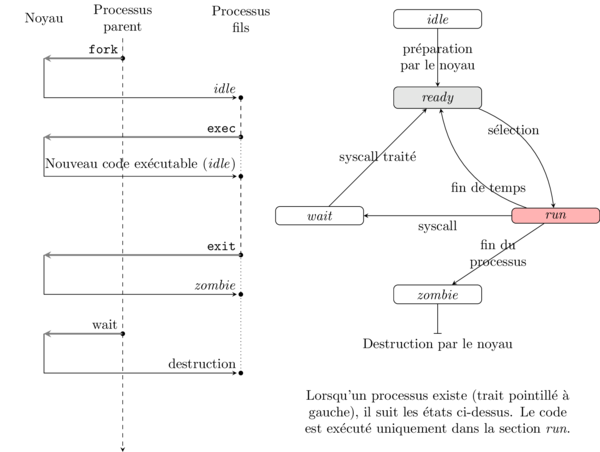

In [8]:
u.tikz("process-life","-l positioning -s 600,600",r'''
\tikzstyle{sized}=[text width=2cm,text centered]
\tikzstyle{state}=[text width=2cm,text centered,rounded corners=3pt,draw=black]
\tikzstyle{queue}=[text width=2cm,text centered,rounded corners=3pt,draw=black,fill=black!10]
\tikzstyle{blackdot}=[fill=black]
\tikzstyle{syscall}=[very thick,gray,-stealth]
\tikzstyle{nulltime}=[dotted,black]
\tikzstyle{time}=[dashed,thin,black]
\tikzstyle{fulltime}=[thin,black]
\def\blackdot#1#2#3{\draw [fill=black] (#2) circle (0.05) coordinate (#1) node[anchor=south east] {#3}}
\def\syscall#1{%
\draw[syscall] (#1)--(#1-|kernel);
\draw[fulltime,-stealth,shorten >=3pt] (#1-|kernel)--(#1done-|kernel)--(#1done)%
}
\draw (0,0) node[sized] (ppid) {%
Processus parent
};
\draw (-2,0) node[sized] (kernel) {%
Noyau
};
\draw (3,0) node[sized] (pid) {%
Processus fils
};
\blackdot{fork}{0,-1}{\texttt{fork}};
\blackdot{forkdone}{3,-2}{\emph{idle}};
\blackdot{exec}{3,-3}{\texttt{exec}};
\blackdot{execdone}{3,-4}{Nouveau code exécutable (\emph{idle})};
\blackdot{exit}{3,-6}{\texttt{exit}};
\blackdot{exitdone}{3,-7}{\emph{zombie}};
\blackdot{waitpid}{0,-8}{wait};
\blackdot{waitpiddone}{3,-9}{destruction};

\draw[time] (ppid)--(fork) [blackdot];
\syscall{fork};
\draw[time] (forkdone)--(exec);
\draw[nulltime] (exec)--(execdone);
\draw[time] (execdone)--(exit);
\syscall{exec};
\syscall{exit};
\syscall{waitpid};
\draw[nulltime] (exit)--(waitpiddone);
\draw[time] (fork)--(waitpid);
\draw[time,-stealth] (waitpid)--+(0,-3);
\begin{scope}[xshift=8cm]
    \node (xidle) [state] at (0,0) {\emph{idle}};
    \node (ready) [queue] at (0,-2) {\emph{ready}};
    \node (run) [state,fill=red!30] at (3,-5) {\emph{run}};
    \node (wait) [state] at (-3,-5) {\emph{wait}};
    \node (xzombie) [state] at (0,-7) {\emph{zombie}};
    \coordinate (xdead) at (0,-8);
    \coordinate (caption) at (0,-10);
    \draw (xidle) edge[-stealth] node[sized] {préparation par le noyau} (ready);
    \draw (ready) edge[bend left,-stealth] node[pos=0.3] {sélection} (run);
    \draw (run) edge[bend left,-stealth] node[pos=0.3] {fin de temps} (ready);
    \draw (run) edge[-stealth] node[below] {syscall} (wait);
    \draw (wait) edge[-stealth] node[sized] {syscall traité} (ready);
    \draw (run) edge[-stealth] node[sized] {fin du processus} (xzombie);
    \node [text width=8cm,text centered] at (caption) {Lorsqu'un processus existe (trait pointillé à gauche), il suit les états ci-dessus. Le code est exécuté uniquement dans la section \emph{run}.};
\end{scope}
    \draw [-Bar] (xzombie)--(xdead) node[below]{Destruction par le noyau};
''')

In [9]:
u.activite("Le cycle de vie du processus")
u.mark("Repérer sur le schéma de droite les moments où le processus est dans une file d'attente ordonnée, et les moments où il est juste dans la table des processus à attendre qu'une condition externe lui permette de changer d'état")
u.solution("il n'est dans une file d'attente que dans l'état READY, tous les autres sont des états intermédiaires où la vie du processus est conditionné par un changement externe")
u.mark("Un shell veut lancer un nouveau programme (par exemple `/bin/ls`). Lister dans l'ordre les appels systèmes qui vont être effectués.")
u.solution(r'''Réponse complète : le shell est le processus parent. Il va commencer par créer des communications entre ses propres descripteurs de fichiers (le mécanisme n'est pas au programme), puis il va se cloner (`fork`). Le clone-fils va réarranger ses communications (hors-programme) pour avoir STDIN et STDOUT au bon endroit, puis se réincarner en `/bin/ls` par un `exec`. Pendant ce temps, le shell (parent, donc) va gérer l'affichage du terminal par les canaux de communication, et de temps en temps, faire un `wait` pour voir si son fils est passé dans l'état zombie. Lorsque le `wait` répondra positivement au fait que le fils est un zombie, le processus fils sera définitivement retiré des tables du noyau.
Réponse simple : le shell est le processus parent. Il va commencer par se cloner (`fork`). Le clone-fils va se réincarner en `/bin/ls` par un `exec`. Pendant ce temps, le shell (parent, donc) va gérer l'affichage du terminal par les canaux de communication, et de temps en temps, faire un `wait` pour voir si son fils est passé dans l'état zombie. Lorsque le `wait` répondra positivement au fait que le fils est un zombie, le processus fils sera définitivement retiré des tables du noyau.''')

#### Activité : Le cycle de vie du processus

Repérer sur le schéma de droite les moments où le processus est dans une file d'attente ordonnée, et les moments où il est juste dans la table des processus à attendre qu'une condition externe lui permette de changer d'état

Votre proposition > `_____________________________________________________`

**Solution:** il n'est dans une file d'attente que dans l'état READY, tous les autres sont des états intermédiaires où la vie du processus est conditionné par un changement externe

Un shell veut lancer un nouveau programme (par exemple `/bin/ls`). Lister dans l'ordre les appels systèmes qui vont être effectués.

Votre proposition > `_____________________________________________________`

**Solution:** Réponse complète : le shell est le processus parent. Il va commencer par créer des communications entre ses propres descripteurs de fichiers (le mécanisme n'est pas au programme), puis il va se cloner (`fork`). Le clone-fils va réarranger ses communications (hors-programme) pour avoir STDIN et STDOUT au bon endroit, puis se réincarner en `/bin/ls` par un `exec`. Pendant ce temps, le shell (parent, donc) va gérer l'affichage du terminal par les canaux de communication, et de temps en temps, faire un `wait` pour voir si son fils est passé dans l'état zombie. Lorsque le `wait` répondra positivement au fait que le fils est un zombie, le processus fils sera définitivement retiré des tables du noyau.
Réponse simple : le shell est le processus parent. Il va commencer par se cloner (`fork`). Le clone-fils va se réincarner en `/bin/ls` par un `exec`. Pendant ce temps, le shell (parent, donc) va gérer l'affichage du terminal par les canaux de communication, et de temps en temps, faire un `wait` pour voir si son fils est passé dans l'état zombie. Lorsque le `wait` répondra positivement au fait que le fils est un zombie, le processus fils sera définitivement retiré des tables du noyau.

### L'arbre des processus

Chaque processus est identifié, de façon unique, par un identifiant appelé PID. Comme chaque processus est engendré par un parent, on peut également donner à chaque processus l'identifiant de son parent, appelé PPID.

À partir de ces deux données, on peut donc construire une structure d'arbre sur les processus.

Les données sur les processus sont accessibles à travers une commande principale `ps`. Plusieurs autres permettent de donner des informations similaires mais plus agréables à lire :

  * `top` permet un affichage en temps réel (trié par utilisation du processeur par défaut)
  * `pstree` permet d'afficher l'arbre des processus directement

L'usage de la commande `ps` est très simple (elle marche sans arguments), mais un certain nombre d'arguments viennent augmenter son utilité :

In [10]:
%%sh
if [ -x /usr/bin/pstree ]; then
    COLUMNS=100
    export COLUMNS
    pstree -U
else
    echo "Désolé, pstree n'est pas disponible sur ce système"
fi

systemd─┬─AgentAntidote───AgentAntidote.b───22*[{AgentAntidote.b}]
        ├─ModemManager───2*[{ModemManager}]
        ├─NetworkManager─┬─dhclient
        │                └─2*[{NetworkManager}]
        ├─accounts-daemon───2*[{accounts-daemon}]
        ├─acpid
        ├─alsactl
        ├─atd
        ├─avahi-daemon───avahi-daemon
        ├─boltd───2*[{boltd}]
        ├─colord───2*[{colord}]
        ├─cron
        ├─cups-browsed───2*[{cups-browsed}]
        ├─cupsd───{cupsd}
        ├─dbus-daemon
        ├─gdm3─┬─gdm-session-wor─┬─gdm-x-session─┬─Xorg───3*[{Xorg}]
        │      │                 │               ├─gnome-session-b─┬─AgentConnectix───AgentConnecti+
        │      │                 │               │                 ├─evolution-alarm───5*[{evolutio+
        │      │                 │               │                 ├─gnome-shell─┬─chrome─┬─2*[cat]
        │      │                 │               │                 │             │        ├─chrome─+++
        │      │          

In [11]:
u.activite("Comparer les options de ps")
u.mark(r'''Comparer le résultat de la commande `ps` avec les options suivantes :

  * `ps`
  * `ps -e`
  * `ps -e -f`
  * `ps -e -f --forest`
  * `ps -o pid:8,ppid:8,user:20,%cpu,args`
  * `ps -o pid:8,ppid:8,user:20,%cpu,args --sort=-%cpu,pid`

''')


#### Activité : Comparer les options de ps

Comparer le résultat de la commande `ps` avec les options suivantes :

  * `ps`
  * `ps -e`
  * `ps -e -f`
  * `ps -e -f --forest`
  * `ps -o pid:8,ppid:8,user:20,%cpu,args`
  * `ps -o pid:8,ppid:8,user:20,%cpu,args --sort=-%cpu,pid`



### Les signaux

Si la communication inter-processus est un champ entier de la recherche en informatique, la communication la plus basique entre processus est très simple. Les processus peuvent recevoir un _signal_ envoyé par le système, et réagir en fonction du _numéro_ de ce signal (une valeur entre 1 et 31). Il n'est pas possible d'envoyer une information plus précise par ce biais. Et la réaction pré-programmée est parfois non-modifiable. C'est un système simple, mais qui permet sans configuration des actions basiques.

L'envoi de signaux peut se faire de deux façons :

  * Certaines combinaisons de touche du terminal permettent de dire au shell d'envoyer un signal au processus qui est actuellement en _avant-plan_. Par exemple, Control-C envoie le signal 2 au processus, Control-Z envoie le signal 20.
  * La commande `kill` permet d'envoyer le signal de son choix (par défaut le signal TERM)

La commande s'appelle comme ceci parce que la plupart de ces signaux ont une action programmée par défaut pour (à réception), tuer le processus visé (plus ou moins proprement). On peut indiquer les signaux par leur numéro ou par leur nom : `kill -INT 12345` et `kill -2 12345` sont identiques.

Les signaux à connaître :

  * HUP : généré par la fin de session (arrête le programme)
  * INT : généré par control-C, « interruption » (arrête le programme)
  * QUIT : généré par la fin de session (arrête le programme)
  * KILL : ne peut pas être masqué (arrête le programme)
  * PIPE : généré par l'arrêt d'un programme récepteur d'un pipe pour le programme émetteur (arrête le programme)
  * CONT : permet à un programme suspendu de reprendre
  * STOP et TSTP : permet de suspendre un programme (le deuxième est généré par control-Z)

### La gestion des processus dans le shell

La paire CONT — STOP/TSTP permet en particulier de gérer les processus qui utilisent le terminal quand il y en a plusieurs en même temps.

Lorsqu'on lance une commande suivie d'une esperluette (&), la commande est lancée en tâche de fond. Elle ne peut pas accéder à STDIN.
Lorsqu'on suspend une commande (pas en tâche de fond), un numéro de job s'affiche

    user@host:~$ sleep 30
    ^Z
    [1]+  Stoppé                 sleep 30

Le numéro de job peut être utilisé ensuite avec les commandes `bg` et `fg` en mettant un `%` devant. `bg %1` passera le job en tâche de fond, et `fg %1` passera le job en _avant-plan_. On ne peut pas passer un job en avant-plan parce que quand un job est en avant-plan, on ne peut pas saisir de commande dans le shell (le clavier est « connecté » au programme, plus au shell).

La commande `sleep` suivi d'un nombre entier de secondes ne fait rien pendant le nombre de secondes indiqué, puis s'arrête.

In [12]:
%%sh
echo "La liste des signaux est :"
/bin/kill -L

La liste des signaux est :
 1 HUP      2 INT      3 QUIT     4 ILL      5 TRAP     6 ABRT     7 BUS
 8 FPE      9 KILL    10 USR1    11 SEGV    12 USR2    13 PIPE    14 ALRM
15 TERM    16 STKFLT  17 CHLD    18 CONT    19 STOP    20 TSTP    21 TTIN
22 TTOU    23 URG     24 XCPU    25 XFSZ    26 VTALRM  27 PROF    28 WINCH
29 POLL    30 PWR     31 SYS     


In [13]:
u.activite("Tester l'envoi de signaux au clavier")
u.mark(r'''En utilisant la commande `sleep` faire la séquence suivante ou équivalent, et comprendre ce qui se passe à chaque fois:

    sleep 30
    # taper Control-C
    sleep 60
    # taper Control-Z
    fg %1
    # taper Control-Z
    bg %1
    sleep 30 &
    sleep 30 &
    jobs
    sleep 30;jobs
''')


#### Activité : Tester l'envoi de signaux au clavier

En utilisant la commande `sleep` faire la séquence suivante ou équivalent, et comprendre ce qui se passe à chaque fois:

    sleep 30
    # taper Control-C
    sleep 60
    # taper Control-Z
    fg %1
    # taper Control-Z
    bg %1
    sleep 30 &
    sleep 30 &
    jobs
    sleep 30;jobs


In [14]:
u.activite("Tester l'envoi de signaux par `kill`")
u.mark(r'''En utilisant deux terminaux, faire la séquence suivante ou équivalent, et comprendre ce qui se passe à chaque fois:

    sleep 60 & # Terminal 1
    ps -e -f -o user,pid,args | grep sleep # Terminal 2 : trouver le PID du sleep 60 du terminal 1
    MONPID=... # mettre le bon numéro de processus (Terminal 2)
    kill -INT $MONPID # ou kill -2 $MONPID (Terminal 2)
    # Observer ce qui se passe dans le terminal 1
    # On repasse dans le terminal 1
    echo '#!/bin/sh' 1> /tmp/a.sh
    echo 'echo "Mon PID est $$"' 1>> /tmp/a.sh # la variable spéciale $$ contient le PID
    echo 'trap date INT' 1>> /tmp/a.sh
    echo "while true; do sleep 1; echo 'coucou'; done" 1>> /tmp/a.sh
    sh /tmp/a.sh # Terminal 1
    # Observer ce qui se passe dans le terminal 1
    # Essayer de l'arrêter avec Control-C
    # Essayer de l'arrêter avec un `kill -2` depuis le terminal 2
    # L'arrêter avec un `kill -15` depuis le terminal 2
''')


#### Activité : Tester l'envoi de signaux par `kill`

En utilisant deux terminaux, faire la séquence suivante ou équivalent, et comprendre ce qui se passe à chaque fois:

    sleep 60 & # Terminal 1
    ps -e -f -o user,pid,args | grep sleep # Terminal 2 : trouver le PID du sleep 60 du terminal 1
    MONPID=... # mettre le bon numéro de processus (Terminal 2)
    kill -INT $MONPID # ou kill -2 $MONPID (Terminal 2)
    # Observer ce qui se passe dans le terminal 1
    # On repasse dans le terminal 1
    echo '#!/bin/sh' 1> /tmp/a.sh
    echo 'echo "Mon PID est $$"' 1>> /tmp/a.sh # la variable spéciale $$ contient le PID
    echo 'trap date INT' 1>> /tmp/a.sh
    echo "while true; do sleep 1; echo 'coucou'; done" 1>> /tmp/a.sh
    sh /tmp/a.sh # Terminal 1
    # Observer ce qui se passe dans le terminal 1
    # Essayer de l'arrêter avec Control-C
    # Essayer de l'arrêter avec un `kill -2` depuis le terminal 2
    # L'arrêter avec un `kill -15` depuis le terminal 2


## Les utilisateurs et les permissions

### Un système, plusieurs utilisateurs

Chaque processus, chaque fichier d'un système est catégorisé comme appartenant à un _utilisateur_. Tous les systèmes ne le sont pas, mais la division d'un système en plusieurs utilisateurs permet d'avoir une meilleure étanchéité entre les composantes d'un système, de gérer plusieurs utilsateurs (humains), de permettre une division plus fines des permissions.

Les utilisateurs sont identifiés par un numéro (surprise), qui peut être converti en un nom (souvent appelé _login_). Ils sont également organisés en groupes (mais un utilisateur peut appartenir à plusieurs groupes).

Les utilisateurs sont — au sens de ce cours — des utilisateurs logiques, et pas des utilisateurs physiques. Il est assez fréquent d'avoir des sous-systèmes d'un serveur qui sont exécutés chacun sous l'identité d'un utilisateur différent (par exemple, le service de mail, le service web, etc.) 

L'authentification est la procédure qui consiste à donner suffisamment d'éléments au système pour valider que les éléments ont été donnés par une personne autorisée précise ; c'est à distinguer des informations sur l'identité, qui consiste plus en la lecture d'une base de données

### Les utilisateurs dans les systèmes UNIX

Les utilisateurs dans les systèmes UNIX sont identifiés par un numéro (UID) et l'appartenance à un ou plusieurs groupes, dont le groupe principale (les groupes eux-mêmes sont identifiés par des numéros : GID).

Les informations sont stockés dans divers endroits, selon les configurations (fichier `/etc/nsswitch.conf`). Toutefois, dans la configuration la plus simple, c'est la paire de fichiers `/etc/passwd` et `/etc/shadow` qui va contenir les informations d'identification (`/etc/passwd`) et d'authentification (`/etc/shadow`).

Dans le système UNIX, tous les utilisateurs sont _a priori_ équivalents, sauf un : l'utilisateur de numéro 0, appelé `root`. Cet utilisateur possède, au niveau du système, des droits particuliers (notamment, il peut ignorer les restrictions de permission). Il est reservé à l'administration du système (pour faire les mises à jour, par exemple).

Il est possible de lister toutes les informations en utilisant la commande `getent` (qui permet de trouver toutes les identités). Les données d'identification sont assez sommaires : _login_, _mot de passe_ (dans la plupart des systèmes, il doit être caché et n'est accessible que dans la table `shadow`, qui n'est lisible que par `root`), _UID_, _GID_, _répertoire personnel_, _shell_. D'autres informations peuvent exister dans d'autres annuaires (comme un annuaire LDAP), mais elles ne relèvent pas du système d'utilisateurs.

In [15]:
%%sh
echo -n "Nombre d'utilisateurs accessibles avec getent : "
getent passwd|wc -l
echo -n "Nombre de groupes accessibles avec getent : "
getent group|wc -l
echo "Informations sur l'utilisateur root :"
getent passwd | grep ^root: 

return 0

Nombre d'utilisateurs accessibles avec getent : 46
Nombre de groupes accessibles avec getent : 78
Informations sur l'utilisateur root :
root:x:0:0:root:/root:/bin/bash


In [16]:
%%sh
echo "Votre groupe principal est \"$(id -gn)\" --- de numéro $(id -g)"
echo "Votre identifiant est \"$(id -un)\" --- de numéro $(id -u)"
echo "Vos groupes sont \"$(id -Gn)\" --- de numéro $(id -G)"


Votre groupe principal est "users" --- de numéro 100
Votre identifiant est "jcdubacq" --- de numéro 1000
Vos groupes sont "users cdrom floppy audio dip video plugdev netdev libvirt kvm" --- de numéro 100 24 25 29 30 44 46 108 122 123


Le système d'utilisateurs a de l'influence sur le système à travers deux mécanismes :

  * Chaque processus tourne avec l'identité d'un utilisateur (et d'un seul)
  * Chaque fichier ou répertoire appartient à un utilisateur et a des permissions qui concernent chaque classe d'utilisateurs du système. Ces permissions peuvent empêcher l'accès au contenu du fichier ou du répertoire.

Ainsi, si un fichier est interdit en lecture à toute autre personne que son propriétaire, aucun processus qui n'appartient pas au propriétaire ne pourra en lire les données (ou même l'ouvrir).

Il est important de connaître le système de permissions.

### Les permissions sous UNIX

Les permissions sous UNIX sont de trois sortes, selon le type d'élément (répertoire ou fichier). Pour les fichiers, on a le droit de :

  * **lire** le contenu du fichier
  * **modifier** le contenu du fichier (et en particulier le remplir quand il est vide)
  * **exécuter** le fichier (ce qui n'a de sens que si c'est un *script* interprétable ou du *code* exécutable).

Pour les répertoires, les permissions sont les suivantes :

  * **consulter le catalogue** du répertoire (on dit souvent **lister**)
  * **modifier le catalogue** du répertoire, ce qui est le droit de créer ou supprimer des fichiers dedans
  * **traverser le répertoire** ce qui permet d'obtenir l'information sur où est situé un élément du catalogue.
  
Il est important de se rappeler ce qu'est un chemin (relatif ou absolu) pour bien comprendre la dernière permission. En effet, pour accéder à un fichier, on passe par son *chemin*, qui est composé d'un enchaînement de répertoires (s'il n'y a que le nom du fichier, on passe en fait par le répertoire appelé `.`). Pour accéder à un fichier, il faut non seulement avoir le droit sur le fichier, mais aussi le droit de traverser tous les répertoires qui le précèdent !

| Nom symbolique | Poids | Fichier | Répertoire |
|-|-|-|-|
| r | 4 | Lecture | Consultation |
| w | 2 | Modification | Modification |
| x | 1 | Exécution | Traversée | 

Les fichiers exécutables, lorsqu'ils sont le premier argument d'une ligne de commande, sont des programmes. La permission d'exécution doit être accordée pour que ça marche, ainsi que la permission de lecture. Si les premiers octets d'un fichier exécutable sont `#!` suivi d'un chemin (ou `#! `) alors c'est un script (et le chemin doit être celui de l'interpréteur), sinon le programme doit être dans un format reconnu par le noyau.

### Les groupements

Il y a trois catégories de permissions pour un même fichier. Ils sont déterminés automatiquement en fonction du _propriétaire_ du fichier et du _groupe_ propriétaire du fichier.

Pour savoir si une identité (utilisateur, groupe) a accès à un fichier, on regarde si :

  * L'utilisateur est le même que le propriétaire. Si oui, alors on utilise la catégorie **propriétaire**.
  * Les groupes de l'utilisateur contiennent le groupe propriétaire. Si oui, alors on utilise la catégorie **groupe**.
  * Sinon, on utilise la catégorie **autre**.
  
Cette classification rudimentaire peut être complété par un système plus complexe (ACL) qui est en dehors de ce cours, qui permet des permissions individuelles.

Pour connaître l’identité du propriétaire d’un processus ou d’un fichier
  * Les commandes top et ps affichent le nom du propriétaire des processus.
  * La commande `ls` avec l’option `-l` affiche le nom et le groupe du propriétaire d’un fichier ou d’un répertoire, de même que la commande `stat`.
  * Les UID et GID sont enregistrés dans le fichier d’administration /etc/passwd ou d’autres mécanismes

Ainsi, chaque fichier a trois paquets de trois permissions, que l'on peut décoder. Par exemple, une permission `rw-r-----` sur un fichier signifie que le propriétaire peut lire et modifier le fichier (mais pas l'exécuter), un utilisateur du même groupe peut le lire (mais pas le modifier ni l'exécuter) et sinon, rien n'est possible.

Les permissions sont regroupées par paquets de 3, et sont parfois codées numériquement selon le code donné plus haut : `rw-r-----` est ainsi équivalent numériquement à `640`.


### Changer les permissions

Les permissions se changent avec la commande `chmod`.

Il y a deux usages de cette commande. L'usage *symbolique* consiste à exprimer sous formes de lettres les permissions que l'on donne ou retire. Par exemple, `chmod ug-wx fichier1 fichier2 fichier3` enlève les droits d'écriture et d'exécution à l'utilisateur et à son groupe sur les trois fichiers. Et `chmod o+r fichier` donne les droits de lecture à tous les utilisateurs *autres* sur le fichier.

Les lettres à utiliser avant le signe `-` ou `+` sont à piocher dans `ugoa` : utilisateur, groupe, autres, tous (un raccourci pour `ugo`).

Le deuxième usage (dit *numérique*) consiste tout simplement à dire quels sont les modes à mettre sous forme numérique. Par exemple si on veut mettre un fichier en lecture seule pour tout le monde (utilisateur, groupe et autres), on utilisera `chmod 444 fichier`.

In [17]:
u.activite("Les bonnes permissions selon les activités")
u.mark(r'''En utilisant les deux notations, dites quelle est la permission la plus adaptée pour le cas proposé.''')
exemples=[['Un fichier public, à modification uniquement par le propriétaire','640'],
          ['Un fichier privé','600'],
          ['Un fichier de travail en groupe','660'],
          ['Un script utilisable par tout les système','755'],
          ['Un script personnel avec un mot de passe écrit en clair dedans','700'],
          ['Un répertoire à accès en lecture publique','755'],
          ['Un répertoire de travail en groupe','770'],
          ['Un répertoire privé','700'],
          ['Un répertoire que seuls ceux qui connaissent le nom des fichiers peuvent exploiter (et le propriétaire)','711']
         ]

def transform(lll):
    s=''
    t=['r','w','x']
    for l in lll:
        ll=int(l)
        for k in range(0,3):
            if ll&(1<<(2-k)):
                s=s+t[k]
            else:
                s=s+'-'
    return(s)
    

for i,j in exemples:
    u.mark(i)
    u.solution("Notation numérique : {0}, notation lettres : `{1}`".format(j,transform(j)))

#### Activité : Les bonnes permissions selon les activités

En utilisant les deux notations, dites quelle est la permission la plus adaptée pour le cas proposé.

Un fichier public, à modification uniquement par le propriétaire

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 640, notation lettres : `rw-r-----`

Un fichier privé

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 600, notation lettres : `rw-------`

Un fichier de travail en groupe

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 660, notation lettres : `rw-rw----`

Un script utilisable par tout les système

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 755, notation lettres : `rwxr-xr-x`

Un script personnel avec un mot de passe écrit en clair dedans

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 700, notation lettres : `rwx------`

Un répertoire à accès en lecture publique

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 755, notation lettres : `rwxr-xr-x`

Un répertoire de travail en groupe

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 770, notation lettres : `rwxrwx---`

Un répertoire privé

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 700, notation lettres : `rwx------`

Un répertoire que seuls ceux qui connaissent le nom des fichiers peuvent exploiter (et le propriétaire)

Votre proposition > `_____________________________________________________`

**Solution:** Notation numérique : 711, notation lettres : `rwx--x--x`

In [18]:
u.activite("Vérifier les permissions")
u.mark(r'''Au moyen de la commande id, affichez votre UID et votre GID ? Comparez-le avec celui de votre
voisin de table. Qu’en concluez-vous ? Comparez-les avec celui de l’utilisateur root. Qu’en
concluez-vous ?''')
u.solution('Les identifiants des étudiants et leur groupes sont construits mécaniquement d\'après l\'annuaire, et ne sont que des nombres. Ce n\'est pas le cas pour les enseignants ou pour les utilisateurs systèmes.')
u.mark(r'''Quels sont vos droits sur le répertoire racine `/`, `/root`, `/tmp`, sur votre répertoire `~/`, et celui de
votre voisin de table `~/../login_voisin` ?''')
u.solution('Normalement, pas de droit d\'écriture mais droit de lecture sur `/`. Les groupes des élèves étant différents, ils sont traités comme des autres et pas comme un groupe et donc ne peuvent pas voir par défaut le contenu des répertoires des voisins. Pour `/tmp`, le réglage est un peu plus compliqué à cause du bit t qui est une propriété particulière dont on ne parle pas dans ce cours, qui empêche certaines suppressions de fichier. Attention à bien faire `ls -ld` ou `stat` pour voir les droits.')
u.mark(r'''Pouvez-vous lire les données contenue dans le répertoire de votre voisin. Quelle commande
permettrait de le faire ? Qui doit lancer la commande ?''')
u.solution('Il faut que le voisin l\'autorise par un `chmod a+x ~` ou `chmod a+rx ~` (les fichiers sont par défaut lisibles de tous, normalement, mais le répertoire personnel n\'est pas traversable.')
u.mark(r'''Donnez les commandes octale et alphanumérique de changement de droits permettant :
  * de créer et d’autoriser aux membres de votre groupe et aux "autres" l’accès en lecture aux images du répertoire `~/public_html/tempo`
  * de créer et donner les droits d’écriture aux membres de votre groupe uniquement (et vous) sur le fichier `~/public_html/tempo/bash.txt`
  * de vous (le propriétaire) retirer toute possibilité de supprimer directement le fichier ci-dessus.''')
u.solution(r'''
  * `mkdir -p ~/public_html/tempo ; chmod a+x ~ ~/public_html ; chmod a+rx ~/public_html/tempo`
  * `touch ~/public_html/tempo/bash.txt ; chmod a-x,g+rw,o-rw ~/public_html/tempo/bash.txt`
  * `chmod -w ~/public_html/tempo` (c'est le seul moyen, les personnes ayant droit d'écriture dans le répertoire peuvent effacer)
''')
u.mark(r'''Imaginez comment donner à votre voisin un accès sous votre répertoire personnel à un répertoire
dans lequel il aurait les droits d’écriture sur un fichier spécifique, que vous ne pourriez vous que lire
(mais pas modifier). Il ne doit pas pouvoir créer un autre fichier chez vous. Comment faites vous pour
effacer ce fichier ?''')
u.solution(r'''Il faut juste créer un fichier, donner les droits d'écriture dessus, et s'enlever les droits d'écriture. Il ne faut pas donner les droits d'écriture sur le répertoire. D'autres solutions sont imaginables. ''')



#### Activité : Vérifier les permissions

Au moyen de la commande id, affichez votre UID et votre GID ? Comparez-le avec celui de votre
voisin de table. Qu’en concluez-vous ? Comparez-les avec celui de l’utilisateur root. Qu’en
concluez-vous ?

Votre proposition > `_____________________________________________________`

**Solution:** Les identifiants des étudiants et leur groupes sont construits mécaniquement d'après l'annuaire, et ne sont que des nombres. Ce n'est pas le cas pour les enseignants ou pour les utilisateurs systèmes.

Quels sont vos droits sur le répertoire racine `/`, `/root`, `/tmp`, sur votre répertoire `~/`, et celui de
votre voisin de table `~/../login_voisin` ?

Votre proposition > `_____________________________________________________`

**Solution:** Normalement, pas de droit d'écriture mais droit de lecture sur `/`. Les groupes des élèves étant différents, ils sont traités comme des autres et pas comme un groupe et donc ne peuvent pas voir par défaut le contenu des répertoires des voisins. Pour `/tmp`, le réglage est un peu plus compliqué à cause du bit t qui est une propriété particulière dont on ne parle pas dans ce cours, qui empêche certaines suppressions de fichier. Attention à bien faire `ls -ld` ou `stat` pour voir les droits.

Pouvez-vous lire les données contenue dans le répertoire de votre voisin. Quelle commande
permettrait de le faire ? Qui doit lancer la commande ?

Votre proposition > `_____________________________________________________`

**Solution:** Il faut que le voisin l'autorise par un `chmod a+x ~` ou `chmod a+rx ~` (les fichiers sont par défaut lisibles de tous, normalement, mais le répertoire personnel n'est pas traversable.

Donnez les commandes octale et alphanumérique de changement de droits permettant :
  * de créer et d’autoriser aux membres de votre groupe et aux "autres" l’accès en lecture aux images du répertoire `~/public_html/tempo`
  * de créer et donner les droits d’écriture aux membres de votre groupe uniquement (et vous) sur le fichier `~/public_html/tempo/bash.txt`
  * de vous (le propriétaire) retirer toute possibilité de supprimer directement le fichier ci-dessus.

Votre proposition > `_____________________________________________________`

**Solution:** 
  * `mkdir -p ~/public_html/tempo ; chmod a+x ~ ~/public_html ; chmod a+rx ~/public_html/tempo`
  * `touch ~/public_html/tempo/bash.txt ; chmod a-x,g+rw,o-rw ~/public_html/tempo/bash.txt`
  * `chmod -w ~/public_html/tempo` (c'est le seul moyen, les personnes ayant droit d'écriture dans le répertoire peuvent effacer)


Imaginez comment donner à votre voisin un accès sous votre répertoire personnel à un répertoire
dans lequel il aurait les droits d’écriture sur un fichier spécifique, que vous ne pourriez vous que lire
(mais pas modifier). Il ne doit pas pouvoir créer un autre fichier chez vous. Comment faites vous pour
effacer ce fichier ?

Votre proposition > `_____________________________________________________`

**Solution:** Il faut juste créer un fichier, donner les droits d'écriture dessus, et s'enlever les droits d'écriture. Il ne faut pas donner les droits d'écriture sur le répertoire. D'autres solutions sont imaginables. 